In [46]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo as ph

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.optimize import linprog

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import warnings
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [2]:
%load_ext blackcellmagic

# Preparation

All the expensive setup happens up here.

In [3]:
np.random.seed(820)
REGULAR_POKEMON = ph.vectorize_pokemon(ph.REGULAR_POKEMON_PATH)
SHINY_POKEMON = ph.vectorize_pokemon(ph.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


# PCA

Plot high-dimensionality data on two axes.

In [4]:
pca = PCA(n_components=2)
pca.fit(REGULAR_POKEMON)
X = pca.transform(REGULAR_POKEMON)
ddf = pd.DataFrame() 
ddf["a"] = pd.Series([x[0] for x in X])
ddf["b"] = pd.Series([x[1] for x in X])
ddf.head(3)

,a,b
0,18.336314,-26.953641
1,7.734955,-17.403369
2,29.769273,11.090012


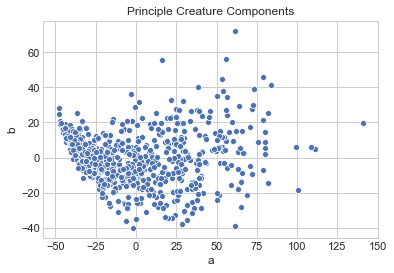

In [5]:
sns.scatterplot(x="a", y="b", data=ddf)
plt.title("Principle Creature Components")
plt.show()

# Clustering

Where do similar vectors fall?

In [6]:
K = 10
kmeans = KMeans(n_clusters=K, random_state=0).fit(REGULAR_POKEMON)
centers = np.uint8(kmeans.cluster_centers_)

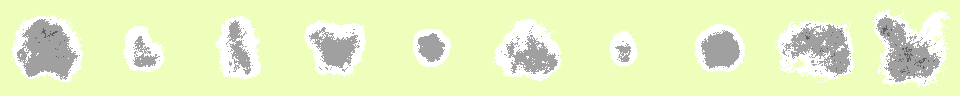

In [7]:
ph.imrow(centers)

In [8]:
ddf["x"] = list(REGULAR_POKEMON)
ddf["cluster"] = kmeans.labels_
ddf[["a", "b", "cluster"]].head(3)

,a,b,cluster
0,18.336314,-26.953641,7
1,7.734955,-17.403369,7
2,29.769273,11.090012,3


# Search Space

Consider a small bounding box within a cluster.

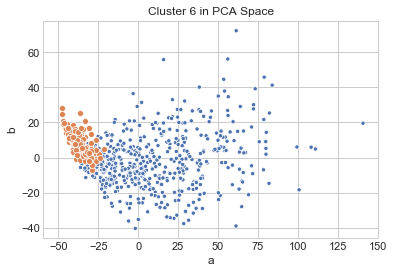

In [9]:
cidx = 6
sns.scatterplot(x="a", y="b", size=0.05, data=ddf)
sns.scatterplot(x="a", y="b", data=ddf.query("cluster == {}".format(cidx)))
plt.title("Cluster {} in PCA Space".format(cidx))
plt.legend().set_visible(False)
plt.show()

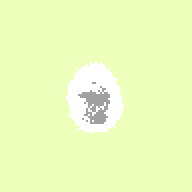

In [10]:
ph.showim(centers[cidx], scale=2)

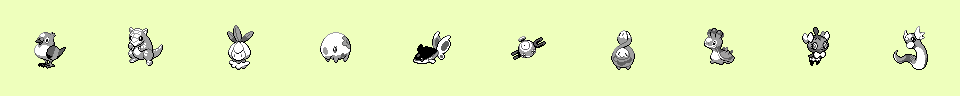

In [11]:
ph.imrow(ddf.query("cluster == {}".format(cidx))["x"].head(10))

In [12]:
cluster_members = np.array(ddf.query("cluster == {}".format(cidx))["x"])
len(cluster_members)

134

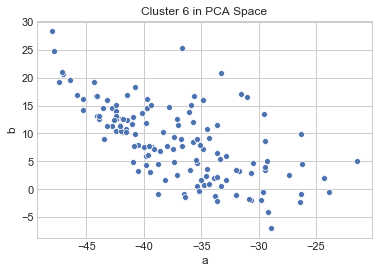

In [13]:
sns.scatterplot(x="a", y="b", data=ddf.query("cluster == {}".format(cidx)))
plt.title("Cluster {} in PCA Space".format(cidx))
plt.show()

In [14]:
ar = (-34, -36)
br = (0, 3)
box_df = (
    ddf.query("cluster == {}".format(cidx))
    .query("a >= {} and a <= -{}".format(*ar))
    .query("b >= {} and b <= {}".format(*br))
)
box_df

,a,b,x,cluster
64,-27.331404,2.463417,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
95,-33.229339,0.568427,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
124,-33.889448,2.037079,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
200,-24.326518,2.076481,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
621,-32.830026,1.677879,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
627,-33.602008,2.267591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
634,-30.657804,2.838656,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


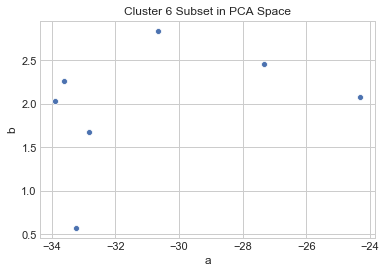

In [15]:
sns.scatterplot(x="a", y="b", data=box_df)
plt.title("Cluster {} Subset in PCA Space".format(cidx))
plt.show()

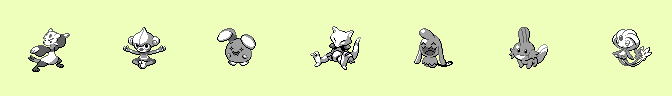

In [16]:
box_x = np.array([x for x in box_df["x"]])
ph.imrow(box_x)

# Linear Optimization

Search for new creatures inside a cluster.

In [26]:
col_sums = np.dot(box_x.T, np.ones(len(box_x)))

In [29]:
active_idxs = []
for i, val in enumerate(col_sums):
    if val > 0:
        active_idxs.append(i)
len(active_idxs)

1694

In [33]:
len(box_x[0][active_idxs]), box_x[0][active_idxs]

(1694, array([0, 0, 0, ..., 4, 4, 4], dtype=uint8))

In [34]:
reduced_vecs = [box_x[i][active_idxs] for i in range(len(box_x))]

In [38]:
col_means = col_sums[active_idxs] / len(box_x)
col_means

array([0.42857143, 0.42857143, 0.42857143, ..., 0.57142857, 0.57142857,
       0.57142857])

In [139]:
n = len(active_idxs)
A = []
b = []
for i in range(n):
    au = np.zeros(n)
    au[i] = 1
    A.append(au)
    b.append(ph.Q)
# Limit total quanta sum
A.append(np.ones(n))
b.append(col_sums[active_idxs].sum())
b[-1]

14695.0

In [168]:
c = [1.5 - avg for avg in col_means]

In [169]:
res = linprog(c, A_ub=A, b_ub=b, options={"maxiter": 500})

In [170]:
res

     fun: -1430.8571428571336
 message: 'Iteration limit reached.'
     nit: 500
   slack: array([4.0000e+00, 4.0000e+00, 4.0000e+00, ..., 4.0000e+00, 4.0000e+00,
       1.2695e+04])
  status: 1
 success: False
       x: array([0., 0., 0., ..., 0., 0., 0.])

In [171]:
min(res.x), max(res.x)

(0.0, 4.0)

In [172]:
sol_vec = [math.floor(v) for v in res.x]
full_vec = np.zeros(ph.M**2)
for i, val in enumerate(sol_vec):
    real_idx = active_idxs[i]
    full_vec[real_idx] = val
full_vec = np.array([int(v) for v in full_vec])

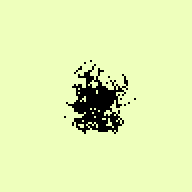

In [173]:
ph.showim(full_vec, scale=2)

In [174]:
trans_x = pca.transform([full_vec])
odf = pd.DataFrame()
odf["x"] = [full_vec]
odf["a"] = [trans_x[0][0]]
odf["b"] = [trans_x[0][1]]
odf["cluster"] = [cidx]
odf.head(1)

,x,a,b,cluster
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-38.478095,1.722786,6


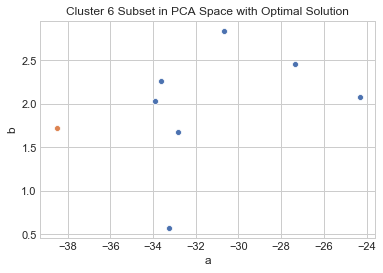

In [175]:
sns.scatterplot(x="a", y="b", data=box_df)
sns.scatterplot(x="a", y="b", data=odf)
plt.title("Cluster {} Subset in PCA Space with Optimal Solution".format(cidx))
plt.show()

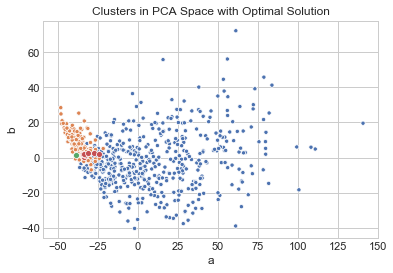

In [176]:
sns.scatterplot(x="a", y="b", size=0.1, data=ddf)
sns.scatterplot(x="a", y="b", size=0.1, data=ddf.query("cluster == {}".format(cidx)))
sns.scatterplot(x="a", y="b", data=odf)
sns.scatterplot(x="a", y="b", data=box_df)
plt.title("Clusters in PCA Space with Optimal Solution".format(cidx))
plt.legend().set_visible(False)
plt.show()

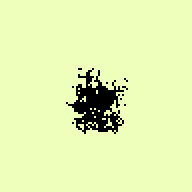

In [177]:
sv = ph.smooth_quanta(full_vec, "dark", 0.5)
ph.showim(sv, scale=2)

In [178]:
AV = pca.components_[0]
BV = pca.components_[1]
AV, BV

(array([-4.07752774e-21, -1.74608489e-22, -3.57732205e-25, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([-3.73473906e-16, -2.02151837e-17,  8.19323206e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]))

In [284]:
def from_pca(p_coord):
    x_prod = np.dot(p_coord, pca.components_)
    cent_vec = [v - x_prod.mean() for v in x_prod]
    xp_vec = [ph.Q if q >= 0 else 0 for q in cent_vec]
    return xp_vec

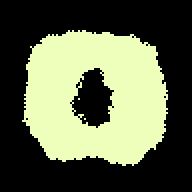

In [285]:
ph.showim(from_pca([-36, 0]), scale=2)

In [280]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [281]:
clust_df = ddf.query("cluster == {}".format(cidx))
clust_df.head(3)

,a,b,x,cluster
8,-39.801852,5.972510,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
12,-35.932290,3.426366,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
18,-37.953780,7.738288,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


In [288]:
step_size = 0.1
frame_df = box_df
a_range = (min(frame_df["a"]), max(frame_df["a"]), step_size)
b_range = (min(frame_df["b"]), max(frame_df["b"]), step_size)
@interact(a=a_range, b=b_range)
def space_handler(a=a_range[0], b=b_range[0]):
    my_df = pd.DataFrame()
    my_df["a"] = [a]
    my_df["b"] = [b]
    #sns.scatterplot(x="a", y="b", color="black", size=0.1, data=clust_df)
    sns.scatterplot(x="a", y="b", color="purple", size=0.1, data=box_df)
    sns.scatterplot(x="a", y="b", color="green", data=my_df)
    plt.title("Clusters in PCA Space with Optimal Solution".format(cidx))
    plt.legend().set_visible(False)
    plt.show()
    img = ph.showim(from_pca([a, b]), scale=2)
    return img

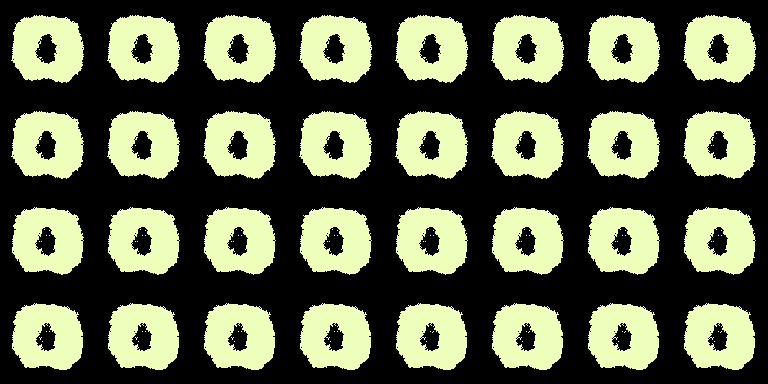

In [320]:
ph.imgrid([[from_pca([a, b]) for a in np.arange(-34, -30, 0.5)] for b in np.arange(0, 2, 0.5)])

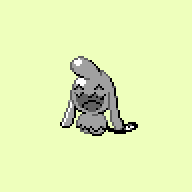

In [290]:
ph.showim(box_x[4], scale=2)

In [302]:
def linop(box_df, opts=None):
    box_x = np.array([x for x in box_df["x"]])
    col_sums = np.dot(box_x.T, np.ones(len(box_x)))
    # Get active columns
    active_idxs = []
    for i, val in enumerate(col_sums):
        if val > 0:
            active_idxs.append(i)
    # Create constraints
    n = len(active_idxs)
    A = []
    b = []
    for i in range(n):
        au = np.zeros(n)
        au[i] = 1
        A.append(au)
        b.append(ph.Q)
    # Limit total quanta sum
    A.append(np.ones(n))
    b.append(col_sums[active_idxs].sum())
    col_means = col_sums[active_idxs] / len(box_x)
    c = [1.5 - avg for avg in col_means]
    res = linprog(c, A_ub=A, b_ub=b, options=opts)
    # Convert to vector space
    sol_vec = [math.floor(v) for v in res.x]
    full_vec = np.zeros(ph.M**2)
    for i, val in enumerate(sol_vec):
        real_idx = active_idxs[i]
        full_vec[real_idx] = val
    full_vec = np.array([int(v) for v in full_vec])
    return res, full_vec

In [311]:
out, sol = linop(ddf.query("cluster == 3"), opts={"maxiter": 500})

In [312]:
out

     fun: -2004.3636363636406
 message: 'Iteration limit reached.'
     nit: 500
   slack: array([4.0000e+00, 4.0000e+00, 4.0000e+00, ..., 4.0000e+00, 4.0000e+00,
       3.1889e+05])
  status: 1
 success: False
       x: array([0., 0., 0., ..., 0., 0., 0.])

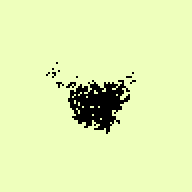

In [313]:
ph.showim(sol, scale=2)